In [ ]:
import xarray as xr
from cartopy import config
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import numpy as np
import datetime
import glob 
import pandas as pd
import seaborn as sns
sns.set()

In [117]:
# # Get a list of all .nc files available in different folders

dir_path = '/Users/jacobqs/Library/CloudStorage/OneDrive-UniversitetetiOslo/MST-HMA/Data/WFDE5'

tair_fn = glob.glob(dir_path + '/near_surface_air_temperature/*.nc')
qair_fn = glob.glob(dir_path + '/near_surface_specific_humidity/*.nc')
wind_fn = glob.glob(dir_path + '/near_surface_wind_speed/*.nc')
rainf_fn = glob.glob(dir_path + '/rainfall_flux/*.nc')
snowf_fn = glob.glob(dir_path + '/snowfall_flux/*.nc')
psurf_fn = glob.glob(dir_path + '/surface_air_pressure/*.nc')
lwdown_fn = glob.glob(dir_path + '/surface_downwelling_longwave_radiation/*.nc')
swdown_fn = glob.glob(dir_path + '/surface_downwelling_shortwave_radiation/*.nc')



In [118]:
tair_ds = xr.open_mfdataset(tair_fn, parallel = True)
#qair_ds = xr.open_mfdataset(qair_fn)
#wind_ds = xr.open_mfdataset(wind_fn)
#rainf_ds = xr.open_mfdataset(rainf_fn)
#snowf_ds = xr.open_mfdataset(snowf_fn)
#psurf_ds = xr.open_mfdataset(psurf_fn)
#lwdown_ds = xr.open_mfdataset(lwdown_fn)
#swdown_ds = xr.open_mfdataset(swdown_fn)

# Hindu Kush-Himalaya

## Time and location

In [119]:
# Dimensions of Tair data set
tair_ds.dims

Frozen({'time': 262968, 'lon': 88, 'lat': 47})

In [120]:
# Data variables in Tair data set
tair_ds.data_vars

Data variables:
    Tair     (time, lat, lon) float32 dask.array<chunksize=(744, 47, 88), meta=np.ndarray>

In [121]:
# Latitude and longitude

lats = tair_ds.lat
lons = tair_ds.lon

In [122]:
# Time

time = tair_ds.time

## Near surface temperature

In [123]:
tair_ds

<xarray.Dataset>
Dimensions:  (time: 262968, lon: 88, lat: 47)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01 ... 2019-12-31T23:00:00
  * lon      (lon) float64 61.25 61.75 62.25 62.75 ... 103.2 103.8 104.2 104.8
  * lat      (lat) float64 16.25 16.75 17.25 17.75 ... 37.75 38.25 38.75 39.25
Data variables:
    Tair     (time, lat, lon) float32 dask.array<chunksize=(744, 47, 88), meta=np.ndarray>
Attributes:
    title:        WATCH Forcing Data methodology applied to ERA5 data
    institution:  Copernicus Climate Change Service
    contact:      http://copernicus-support.ecmwf.int
    comment:      Methodology implementation for ERA5 and dataset production ...
    Conventions:  CF-1.7
    summary:      ERA5 data regridded to half degree regular lat-lon; Genuine...
    reference:    Cucchi et al., 2020, Earth Syst. Sci. Data, 12(3), 2097–212...
    licence:      The dataset is distributed under the Licence to Use Coperni...

In [124]:
# Temperature attributes

tair_attrs = tair_ds.Tair.attrs
print(tair_attrs)

{'long_name': 'Near-Surface Air Temperature', 'standard_name': 'air_temperature', 'units': 'K'}


In [125]:
# Temperature values
#tair_values = tair_ds.Tair.values

### Simple plotting of a single day

#### Using Xarray plot

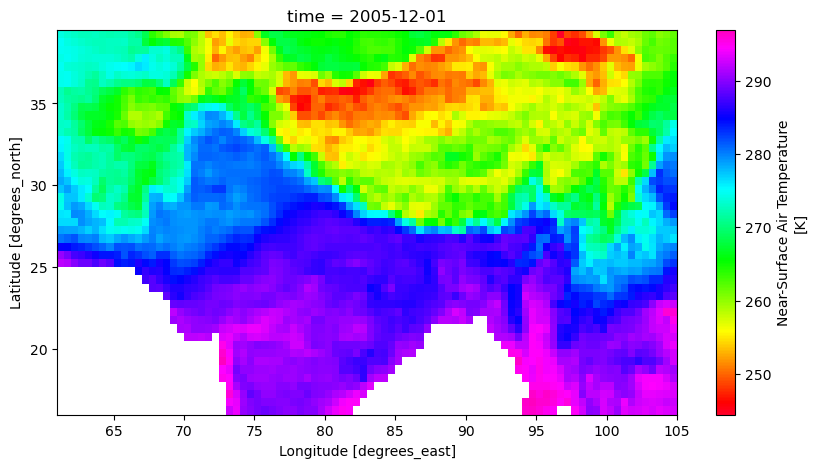

In [126]:
# Simple example plot using Xarray plot 

mytime = datetime.datetime(2005,12,1,0,0,0)
tair_ds.sel(time = mytime).Tair.plot(cmap = 'gist_rainbow', figsize = (10,5))

#### Using Basemap

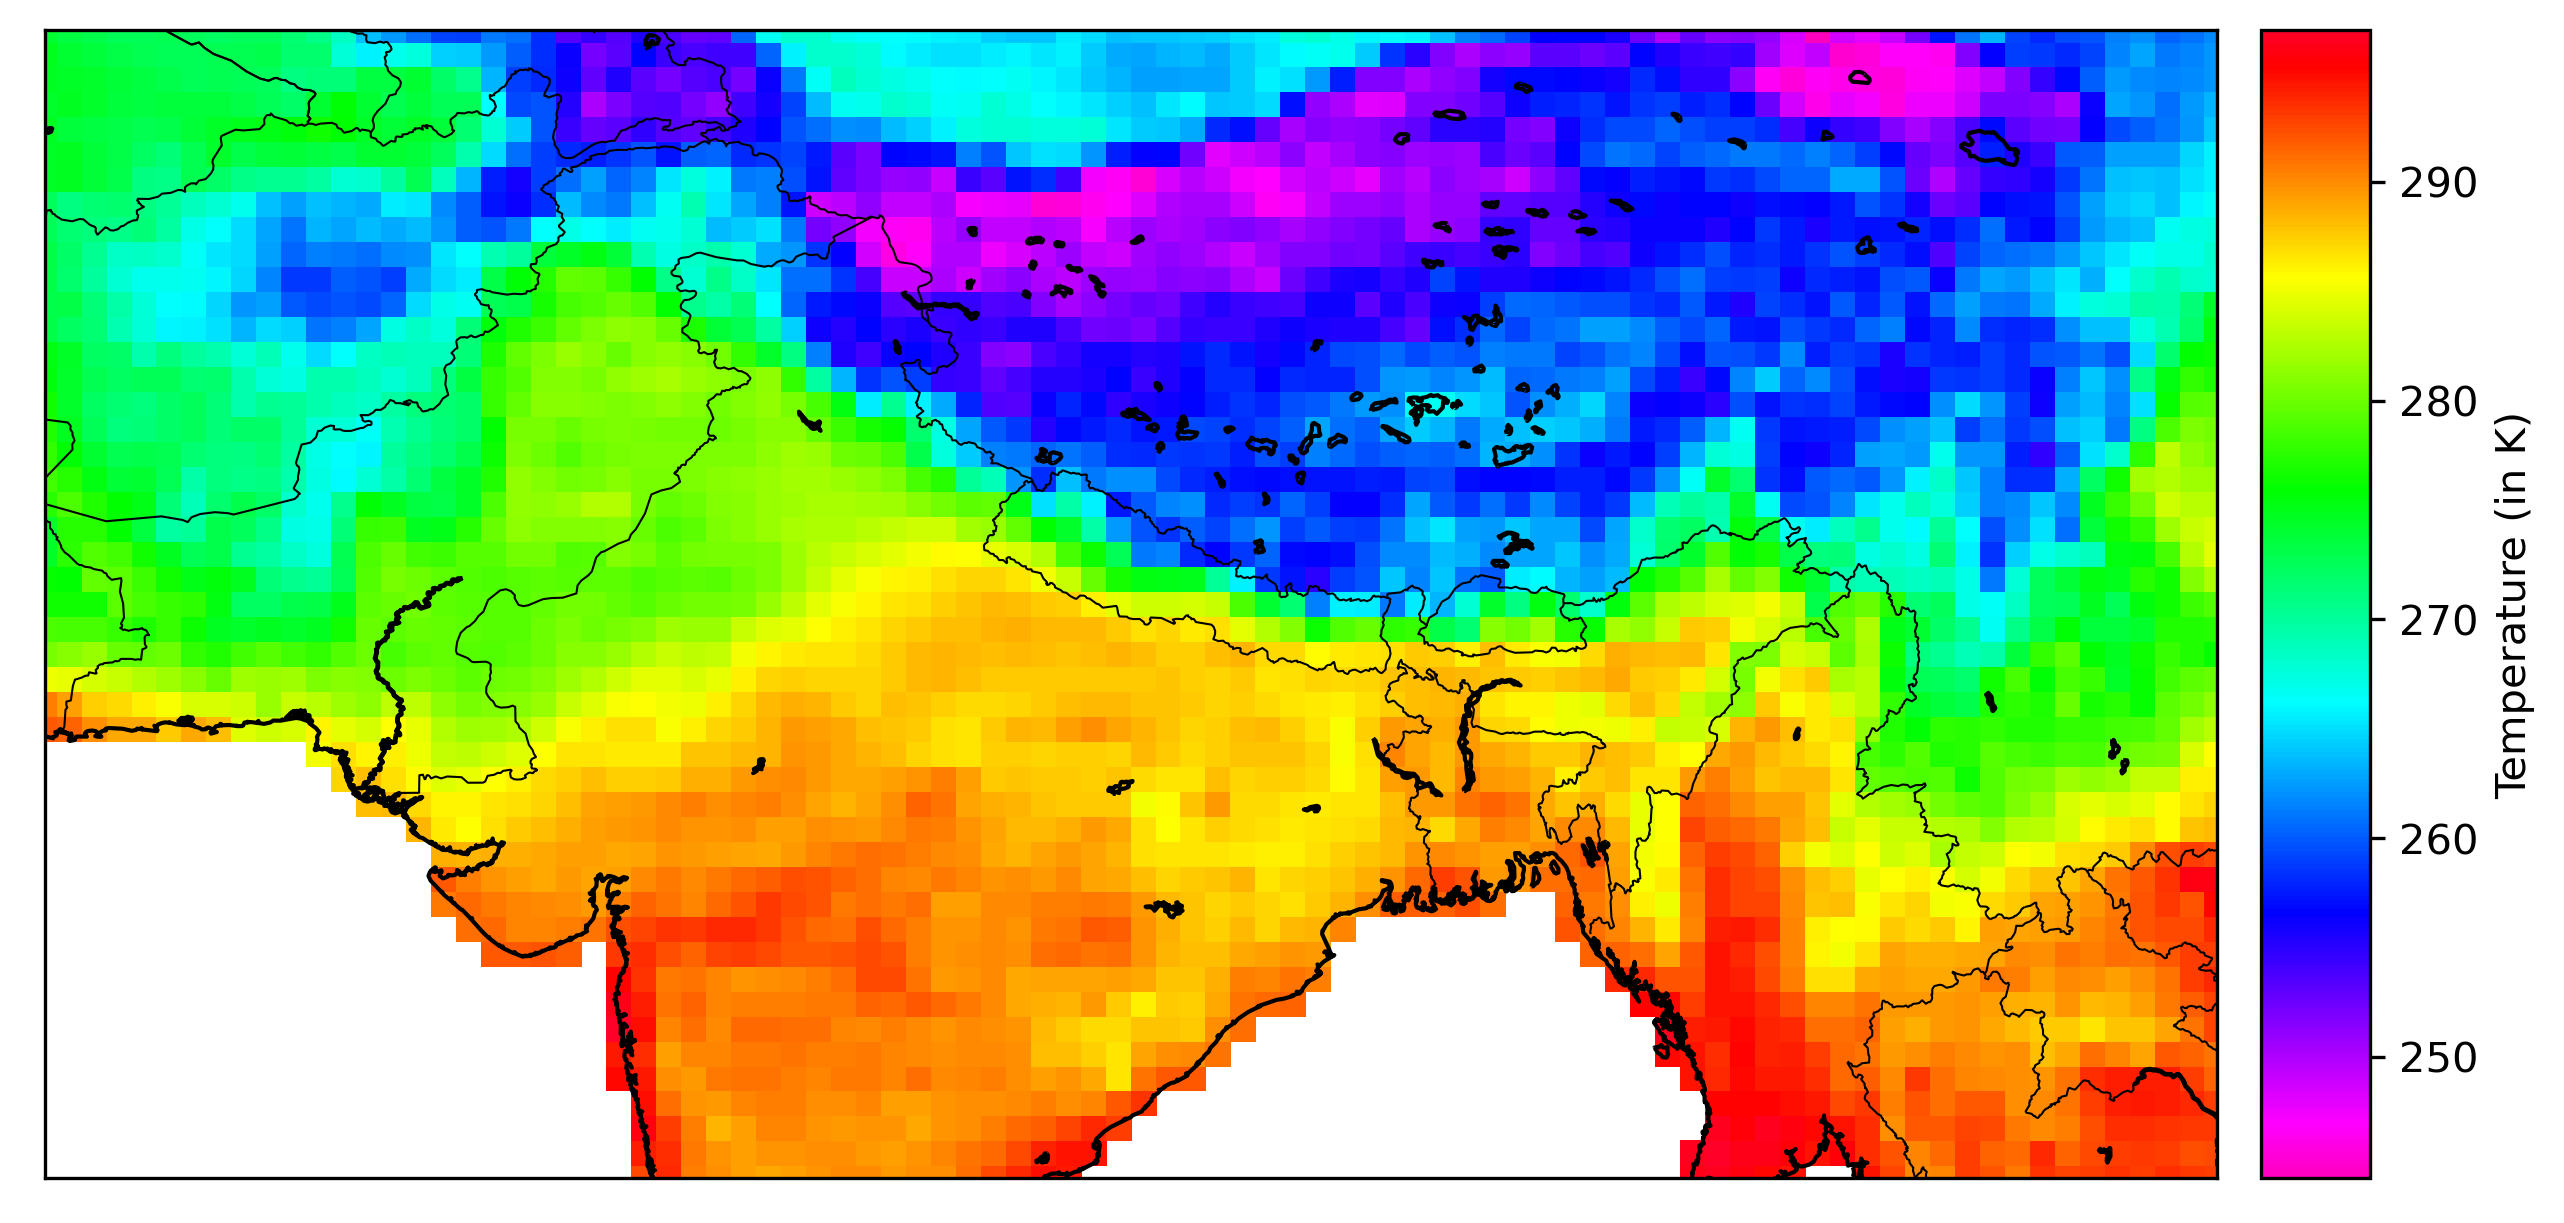

In [127]:
# Simple example plot using Basemap

# HKH coordinate bounds
min_lon = tair_ds.lon.values.min()
min_lat = tair_ds.lat.values.min()
max_lon = tair_ds.lon.values.max()
max_lat = tair_ds.lat.values.max()

# mask the coordinates
mask_lon = (tair_ds.lon >= min_lon) & (tair_ds.lon <= max_lon)
mask_lat = (tair_ds.lat >= min_lat) & (tair_ds.lat <= max_lat)

# clip the dataset for only lat lon inside HKH 
da = tair_ds.where(mask_lon & mask_lat, drop=True)

# select the time
mytime = datetime.datetime(2005, 12, 1, 0, 0, 0)
ds_sel = da.sel(time=mytime)

lat = ds_sel.lat.values
lon = ds_sel.lon.values
tair_sel_vals = ds_sel.Tair.values

mp = Basemap(projection='cyl',
llcrnrlon=min_lon,llcrnrlat=min_lat,
urcrnrlon=max_lon,urcrnrlat=max_lat,resolution='i')
lon,lat = np.meshgrid(lon,lat)
x,y = mp(lon,lat)
plt.figure(figsize=(10, 5),dpi=300)
mp.pcolor(x,y,tair_sel_vals,cmap='gist_rainbow_r')
mp.drawcoastlines()
mp.drawcountries()
mp.colorbar(label="Temperature (in K)")
plt.show()

## Daily, monthly, annually and seasonally timeseries

In [128]:
# Get daily temperature time series

tair_daily = tair_ds.resample(time = '1D').mean()

In [129]:
# Get monthly temperature time series

tair_monthly = tair_ds.resample(time = 'M').mean()

In [130]:
# Get annual temperature time series

tair_annualy = tair_ds.resample(time = 'Y').mean()

In [131]:
# Seasonal time series

tair_seasonally = tair_ds.resample(time = 'QS-DEC').mean()

## Annual mean

### Annual mean temperature 1990-2019

In [132]:
tair_mean = tair_ds.mean(dim = 'time')

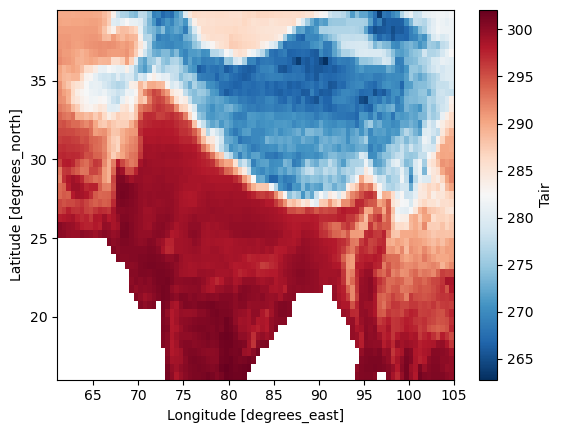

In [133]:
tair_mean.Tair.plot(cmap = plt.cm.RdBu_r)

### Seasonal mean temperature 1990-2019

To get seasonal temperature, we need to calculate the weighted average considering that each month has a different number of days.

In [134]:
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

In [135]:
def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar) and month == 2:
            month_length[i] += 1
    return month_length

In [136]:
# Wrap it into a simple function
def season_mean(ds, calendar='standard'):
    # Make a DataArray of season/year groups
    year_season = xr.DataArray(ds.time.to_index().to_period(freq='Q-NOV').to_timestamp(how='E'),
                               coords=[ds.time], name='year_season')

    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar=calendar),
                                coords=[ds.time], name='month_length')
    # Calculate the weights by grouping by 'time.season'
    weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby('time.season').sum(dim='time')

In [137]:
# Getting annual mean for the period and excluding zero values (for plot)
tair_seasonal_mean = season_mean(tair_ds)
tair_seasonal_mean = tair_seasonal_mean.where(tair_seasonal_mean.Tair > 0)

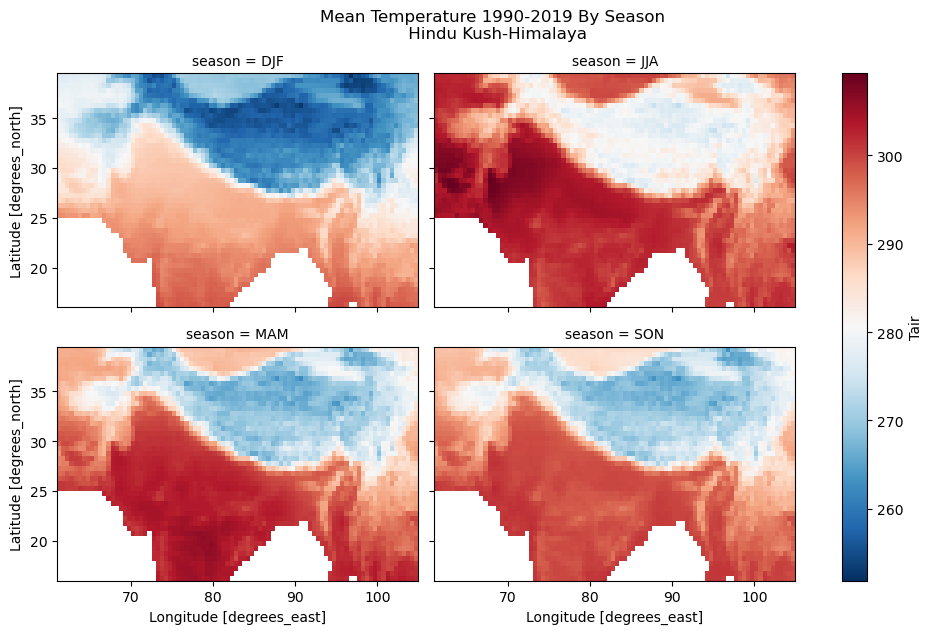

In [138]:
# Create a plot showing mean temperature aross seasons
tair_seasonal_mean.Tair.plot(col='season', col_wrap=2, figsize=(10, 6), cmap = plt.cm.RdBu_r)
plt.suptitle("Mean Temperature 1990-2019 By Season \n Hindu Kush-Himalaya",
             y=1.05)

plt.show()

In [139]:
tair_monthly_mean = tair_monthly.groupby('time.month').mean()

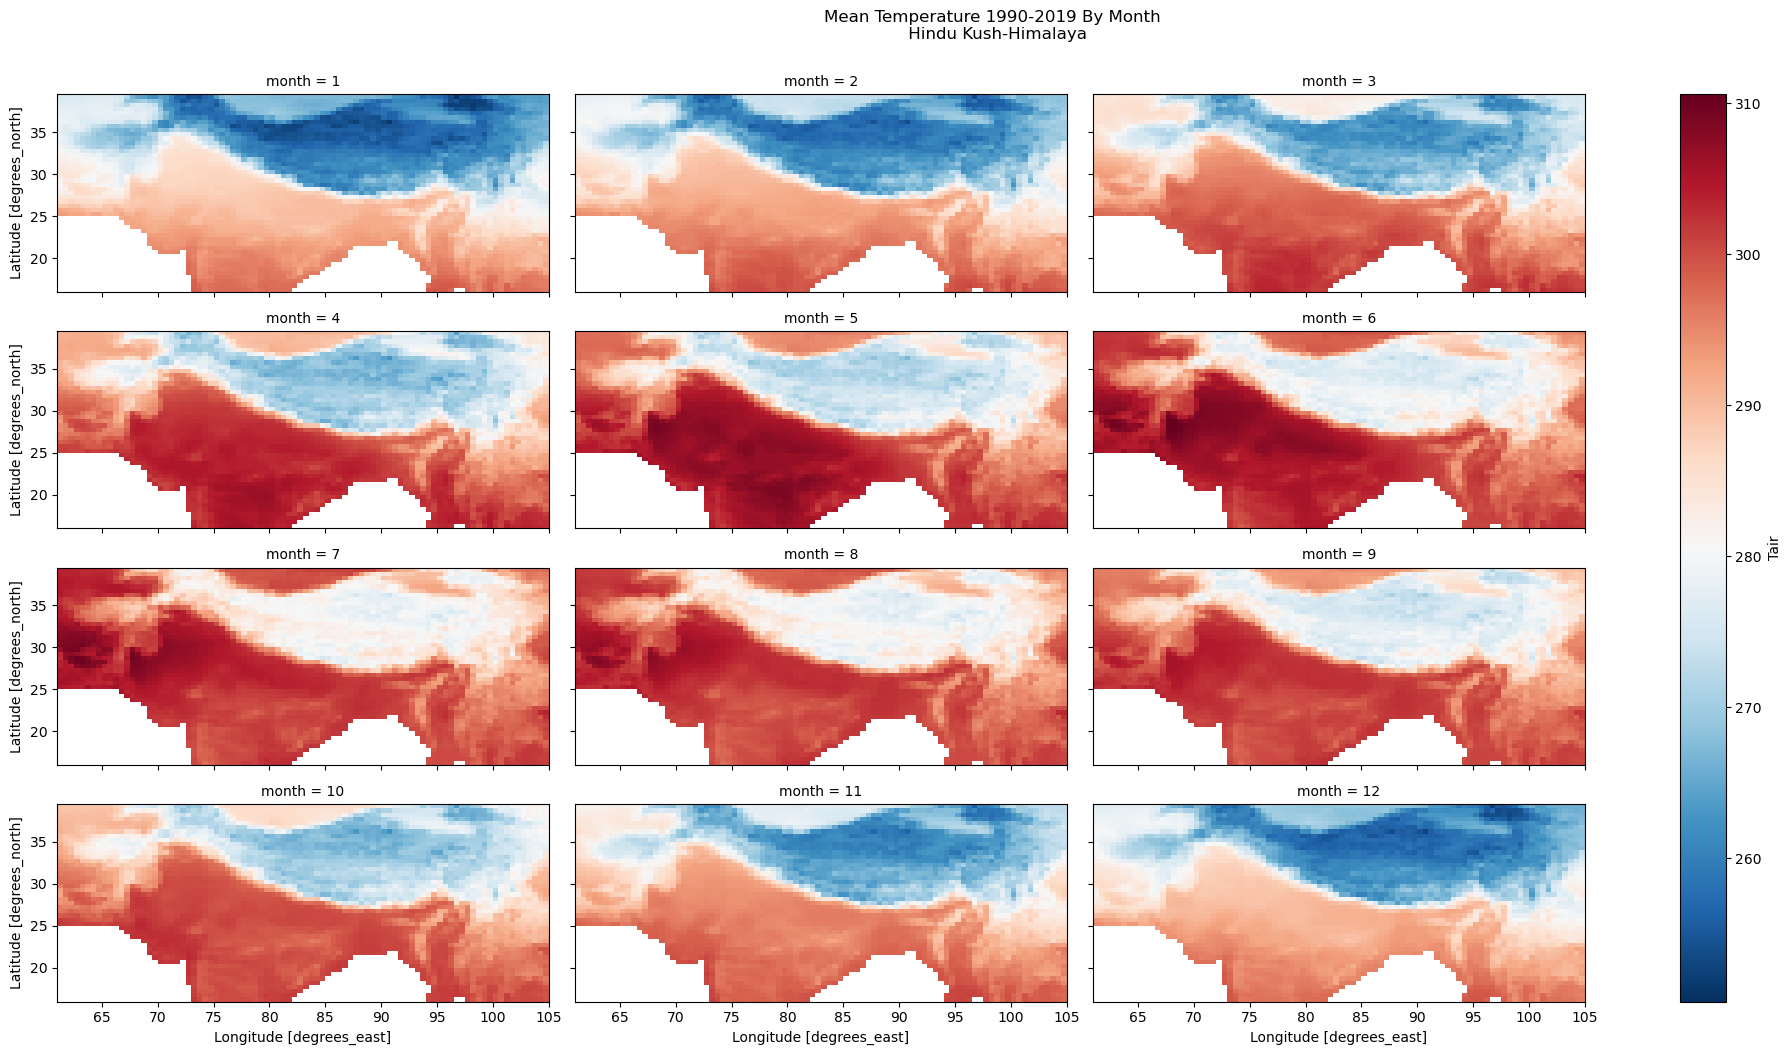

In [140]:
# Create a plot showing mean temperature aross seasons
tair_monthly_mean.Tair.plot(col='month', col_wrap=3, figsize=(20, 10), cmap = plt.cm.RdBu_r)
plt.suptitle("Mean Temperature 1990-2019 By Month \n Hindu Kush-Himalaya",
             y=1.05)

plt.show()

## Time series of globally averaged fields

In [141]:
# Daily mean temp
temp_daily_mean = tair_daily.Tair.mean(dim = ['lon','lat']) # In Kelvin

# Monthly mean temp
temp_monthly_mean = tair_monthly.Tair.mean(dim = ['lon','lat'])

# Annually mean temp
temp_annualy_mean = tair_annualy.Tair.mean(dim = ['lon', 'lat'])

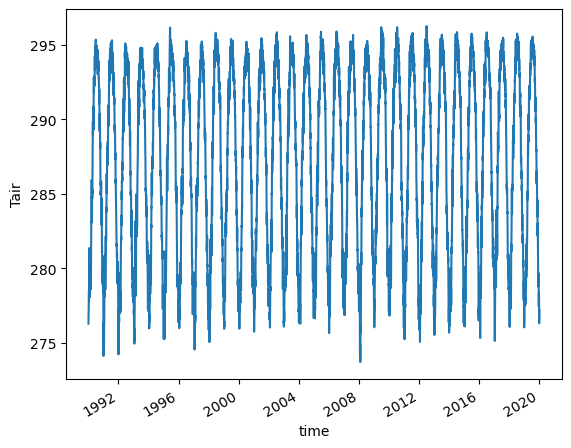

In [142]:
temp_daily_mean.plot()

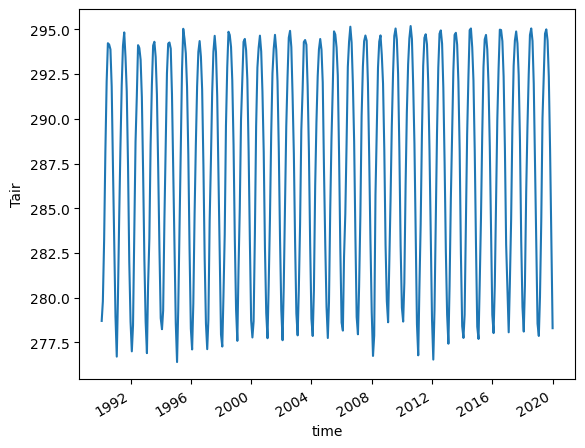

In [143]:
temp_monthly_mean.plot()

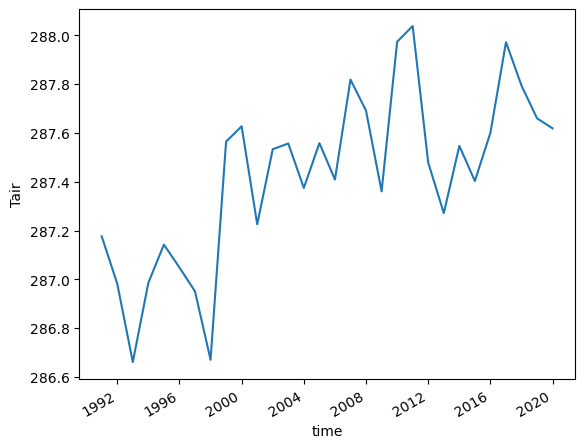

In [144]:
temp_annualy_mean.plot()

## Average monthly temperature range (average max minus average min)

Where is the range of monthly temperature highest? Note the latitudinal differences. Is the variability higher over land or over oceans? Why?

In [145]:
# Monthly time series: tair_monthly
# Max monthly 
temp_max_monthly = tair_ds.resample(time ='M').max()

# Min monthly
temp_min_mean_monthly = tair_ds.resample(time = 'M').min()

# Temp range
temp_monthly_range = temp_max_monthly - temp_min_mean_monthly

# Mean monthly temp range

temp_monthly_mean_range = temp_monthly_range.groupby('time.month').mean()


/Users/jacobqs/opt/miniconda3/envs/geohyd/lib/python3.10/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/Users/jacobqs/opt/miniconda3/envs/geohyd/lib/python3.10/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


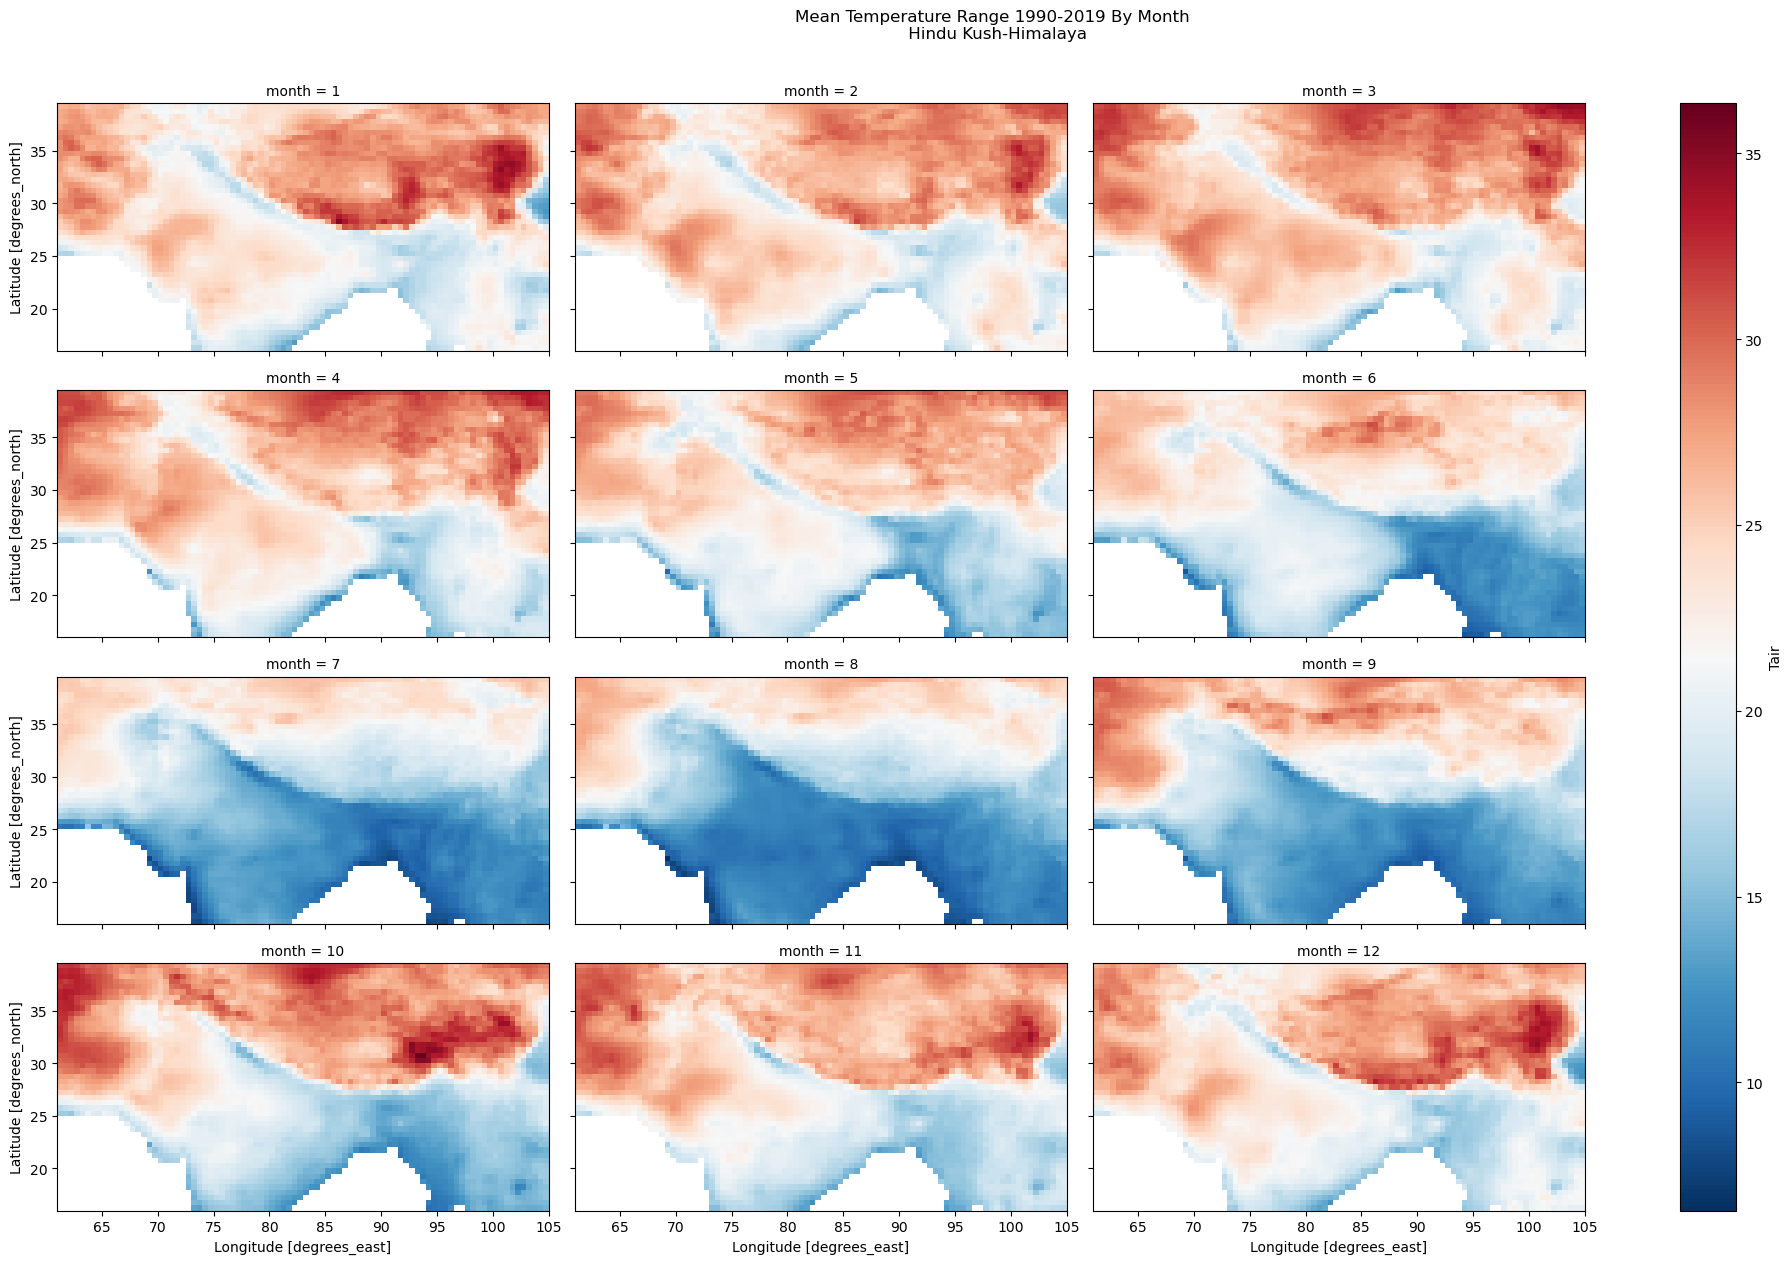

In [146]:
# Create a plot showing mean temperature aross seasons
temp_monthly_mean_range.Tair.plot(col='month', col_wrap=3, figsize=(20, 12), cmap = plt.cm.RdBu_r)
plt.suptitle("Mean Temperature Range 1990-2019 By Month \n Hindu Kush-Himalaya",
             y=1.05)

plt.show()

## Zonal mean temperature

In [147]:
temp_zonal_mean = tair_ds.mean(dim = ['time','lon'])
temp_meridional_mean = tair_ds.mean(dim = ['time','lat'])

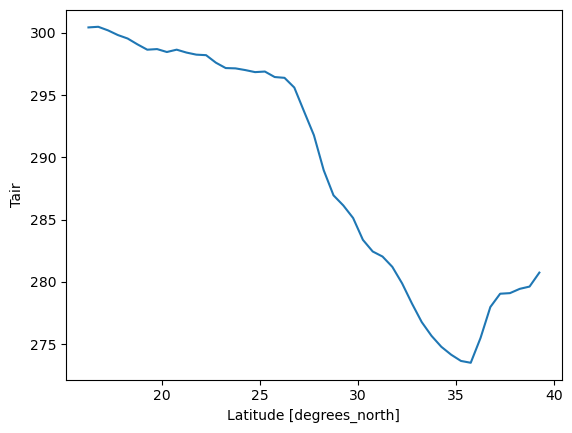

In [148]:
temp_zonal_mean.Tair.plot()

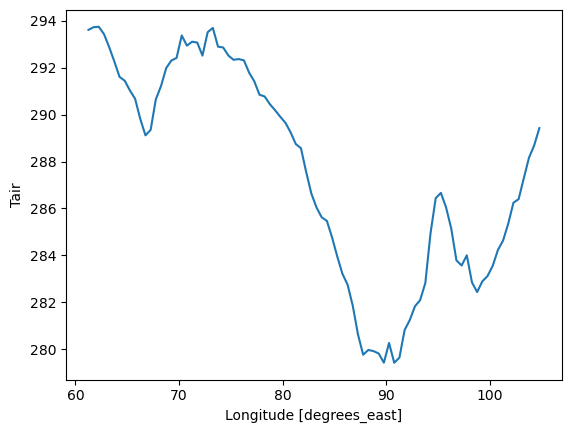

In [149]:
temp_meridional_mean.Tair.plot()

## Temperature lapse rate

In [150]:
# Grid point altitude filename
gpa_filename = '/Users/jacobqs/Library/CloudStorage/OneDrive-UniversitetetiOslo/MST-HMA/Data/WFDE5/grid_point_altitude/f2ba5fd9-db70-4250-8bb9-dafdf1f5ffc8-ASurf_WFDE5_CRU_v2_area_subset.nc'

gpa_ds = xr.open_dataset(gpa_filename)



In [151]:
# Get mean temperature per grid cell

temp_mean_point = tair_ds.mean(dim='time')

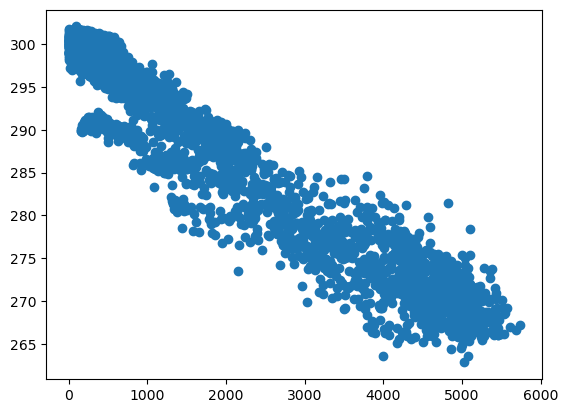

In [152]:
# Temperature vs. elevation
plt.scatter(gpa_ds.ASurf.values, temp_mean_point.Tair.values)

# Trends

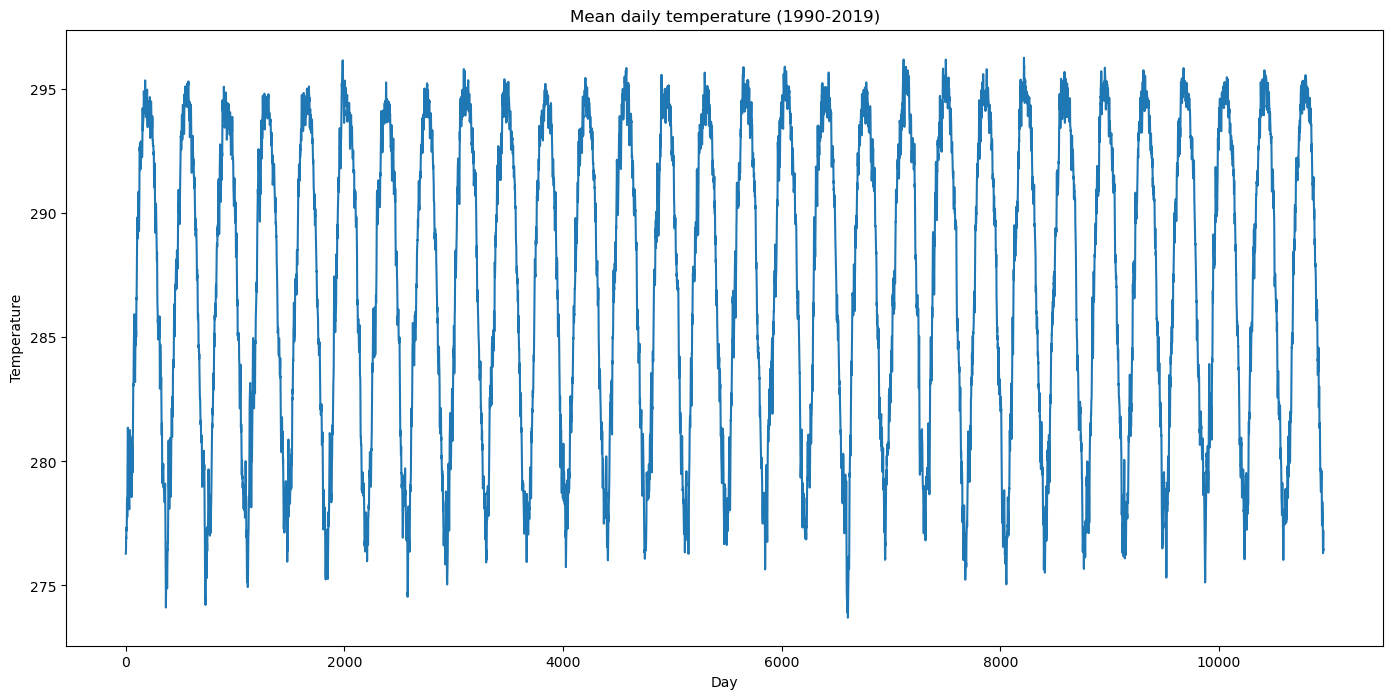

In [156]:

plt.figure(figsize=(17, 8))
plt.plot(temp_daily_mean)
plt.title('Mean daily temperature (1990-2019)')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.grid(False)
plt.show()


In [157]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

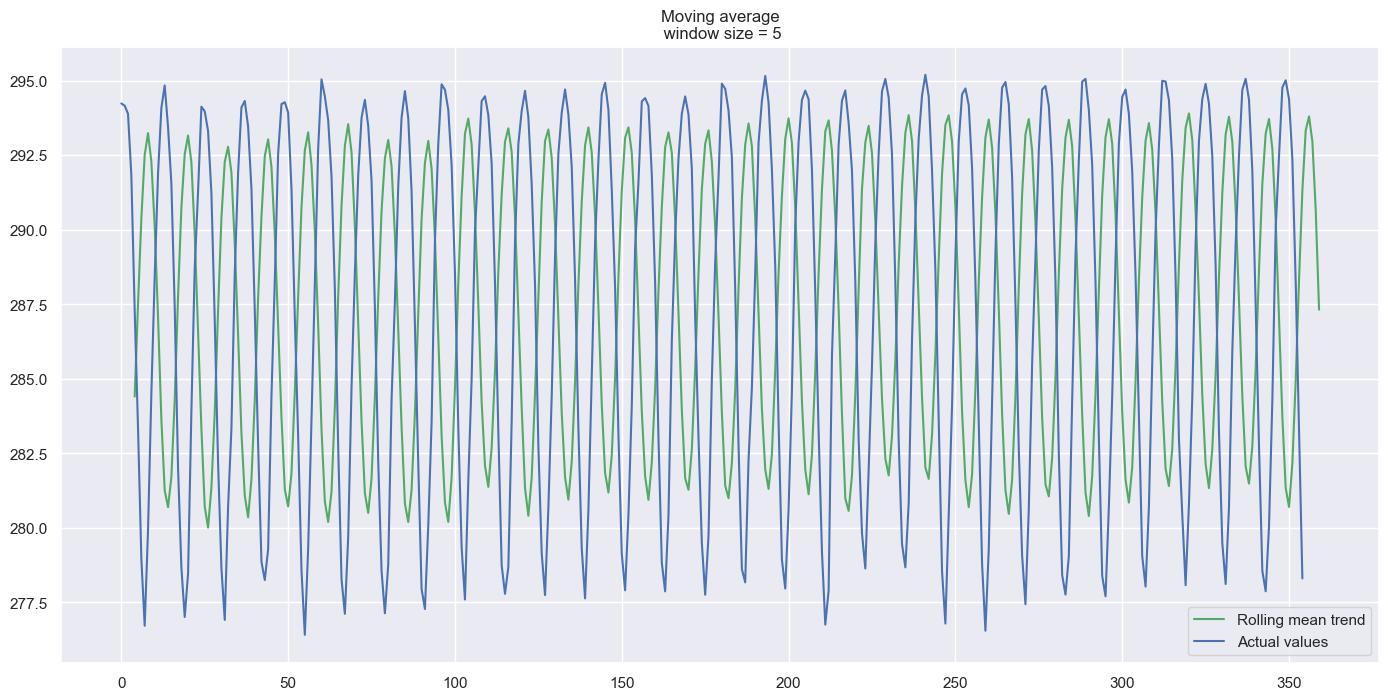

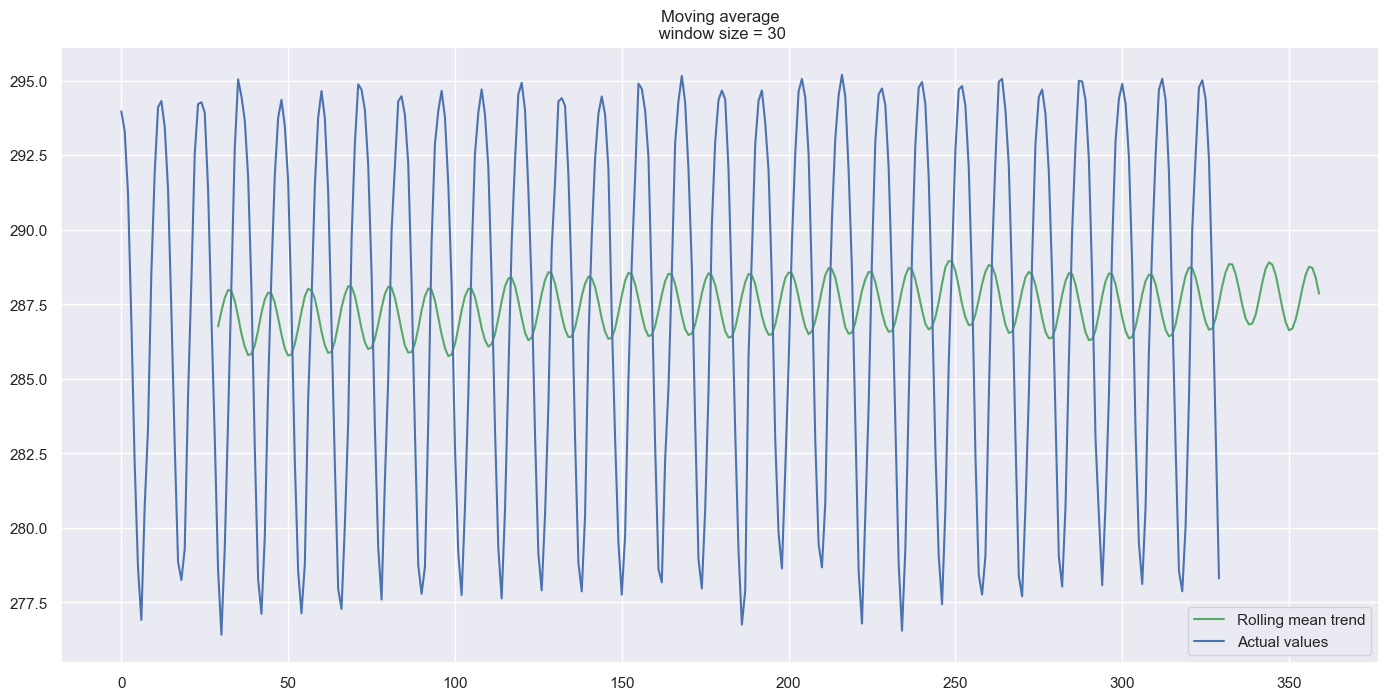

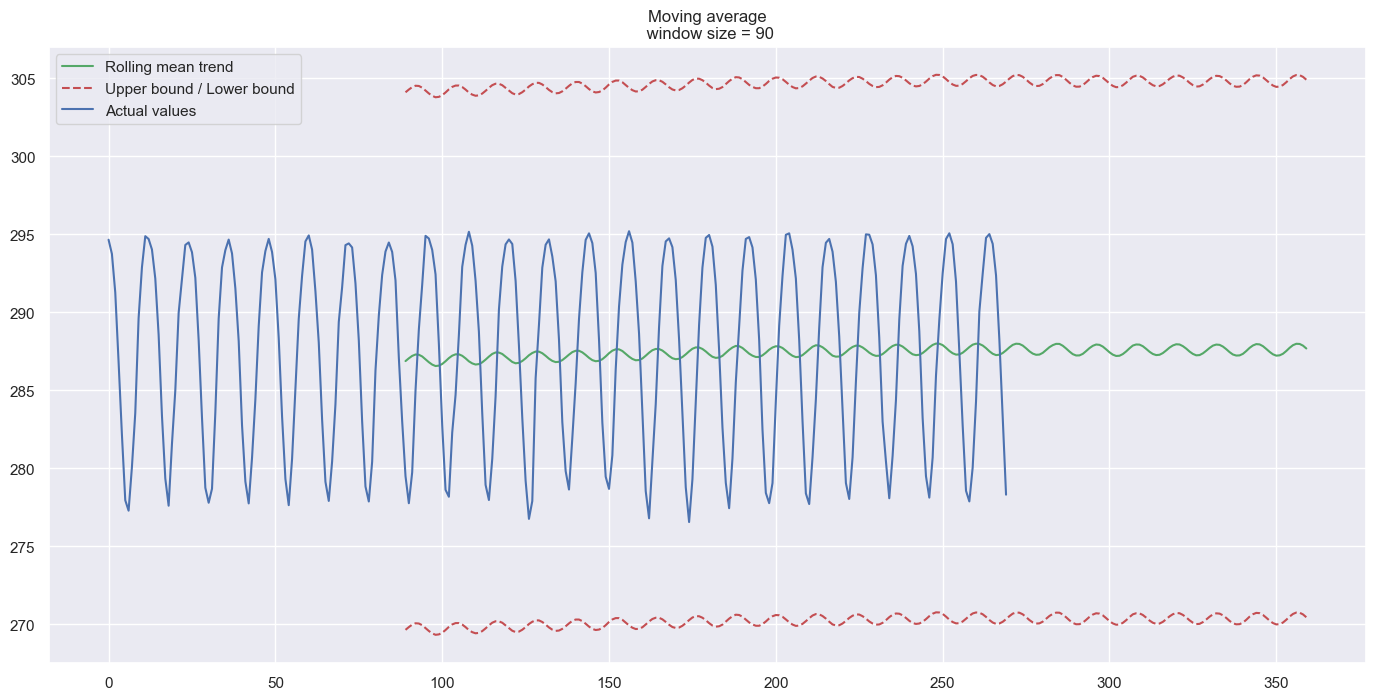

In [166]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(time=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(temp_monthly_mean, window = 5)

#Smooth by the previous month (30 days)
plot_moving_average(temp_monthly_mean, window = 30)

#Smooth by previous quarter (90 days)
plot_moving_average(temp_monthly_mean, window = 90, plot_intervals=True)

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(temp_daily_mean, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = temp_daily_mean - temp_daily_mean.shift(1)

tsplot(data_diff[1:], lags=30)